<a href="https://colab.research.google.com/github/pablohsgc/API_REST/blob/main/Teste_Estrategias_ELET3_CAGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes para ELET3

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4007    0  4007    0     0  16095      0 --:--:-- --:--:-- --:--:-- 16157
100  517k  100  517k    0     0   555k      0 --:--:-- --:--:-- --:--:--  964k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4011    0  4011    0     0  13397      0 --:--:-- --:--:-- --:--:-- 13370
100  392k  100  392k    0     0   426k      0 --:--:-- --:--:-- --:--:--  426k


In [ ]:
#imports necessarios
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import talib as ta
from talib import MA_Type

In [ ]:
!pip install scikit-optimize
!pip install scipy
!pip3 install benchmark_functions

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
resultados_experimento_cagr = {}
resultados_experimento_lucro = {}

In [ ]:
# Funções úteis para plotar resultados
def filter_data(data, data_inicio, data_fim, ultima_compra = None):
  tam = len(data)

  compras = []
  vendas = []
  start = 0
  last_signal = 0

  compra_anterior = ultima_compra

  # encontra primeiro dia válido maior ou igual que a data de inicio
  for i in range(0,tam):
    if str(data["Price"].index[i])[0:10] >= data_inicio:
      start = i
      break

  if ultima_compra:
    # encontra primeira venda
    for i in range(start,tam):
      if data['position'][i] == -1:
        # adiciona primeira compra e marca data
        vendas.append((data.index[i],data["Price"][i]))
        start = i + 1
        last_signal = -1
        break
  else:
    # encontra primeira compra
    for i in range(start,tam):
      if data['position'][i] == 1:
        # adiciona primeira compra e marca data
        compras.append((data.index[i],data["Price"][i]))
        start = i + 1
        last_signal = 1
        break


  for i in range(start,tam):
    # Condicao de parada
    if str(data["Price"].index[i])[0:10] >= data_fim:
      break

    # Armazena venda
    if last_signal == 1 and data['position'][i] == -1:
      vendas.append((data.index[i],data["Price"][i]))
      last_signal = -1
    # Armazena compra
    elif last_signal == -1 and data['position'][i] == 1:
      compras.append((data.index[i],data["Price"][i]))
      last_signal = 1

  ultima_compra = None

  if len(compras) > len(vendas):
    ultima_compra = compras.pop()

  valores_compra = np.array([item[1] for item in compras])
  valores_venda = np.array([item[1] for item in vendas])


  if len(valores_compra) < len(valores_venda) and compra_anterior:
    valores_compra = np.insert(valores_compra,0,compra_anterior[1])

  if (len(valores_compra) == 0 or len(valores_venda) == 0):
    return [],[],0,0

  ror = (valores_venda - valores_compra)/valores_compra
  cagr = np.power(np.prod(ror + 1), 1/len(valores_venda)) - 1

  return compras,vendas,cagr,ultima_compra

def plota_resultados(data,sm,lm,compras,vendas,nome_acao):
  datas_compra = [item[0] for item in compras]
  datas_venda = [item[0] for item in vendas]
  valores_compra = [item[1] for item in compras]
  valores_venda = [item[1] for item in vendas]

  plt.plot(data["Price"],label=nome_acao)
  plt.plot(sm,linewidth=0.5,label="Média curta")
  plt.plot(lm,linewidth=0.5,label="Média longa")
  plt.scatter(datas_compra,valores_compra,marker="^",color="green",label="Compra")
  plt.scatter(datas_venda,valores_venda,marker="v",color="red",label="Venda")
  plt.xlabel("Data")
  plt.ylabel("Cotação de Fechamento")
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

def plota_cagr(cagrs, nome_acao):
  datas = list(cagrs.keys())
  percentuais = list(cagrs.values())

  plt.plot(datas, percentuais,label=nome_acao)
  plt.xlabel("Data")
  plt.ylabel("Percentual de lucro/prejuizo")
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

In [ ]:
def SMA(data, periodS, periodL):

  data["sm"] = ta.SMA(data["Price"], periodS)
  data["lm"] = ta.SMA(data["Price"], periodL)

  #adiciona sinal neutro
  data["position"] = 0

  for i in range(1,len(data)):
    if data["sm"][i] > data["lm"][i] and data["sm"][i-1] <= data["lm"][i-1]: # sinal de compra
      data["position"][i] = 1
    elif data["sm"][i] < data["lm"][i] and data["sm"][i-1] >= data["lm"][i-1]: # sinal de venda
      data["position"][i] = -1

  return data["position"],data["sm"],data["lm"]

# Testes para SMA

## Teste em 10 anos 2013 até 2023

Treino: ( 2013-01-01  -  2016-01-01 ), teste: ( 2016-01-01  -  2016-12-31 )
parametros: [20, 41]
cagr:  0.1626897622763115
ultima compra: (Timestamp('2016-10-17 00:00:00-0200', tz='America/Sao_Paulo'), 10.511090278625488)
compras: [(Timestamp('2016-02-26 00:00:00-0300', tz='America/Sao_Paulo'), 6.338924407958984), (Timestamp('2016-06-28 00:00:00-0300', tz='America/Sao_Paulo'), 8.90907096862793), (Timestamp('2016-10-17 00:00:00-0200', tz='America/Sao_Paulo'), 10.511090278625488)]
vendas: [(Timestamp('2016-05-20 00:00:00-0300', tz='America/Sao_Paulo'), 8.142638206481934), (Timestamp('2016-09-13 00:00:00-0300', tz='America/Sao_Paulo'), 9.375847816467285)]

Treino: ( 2014-01-01  -  2016-12-31 ), teste: ( 2016-12-31  -  2017-12-31 )
parametros: [5, 30]
cagr:  0.17455459879897717
ultima compra: None
compras: [(Timestamp('2016-02-26 00:00:00-0300', tz='America/Sao_Paulo'), 6.338924407958984), (Timestamp('2016-06-28 00:00:00-0300', tz='America/Sao_Paulo'), 8.90907096862793), (Timestamp('2016-1

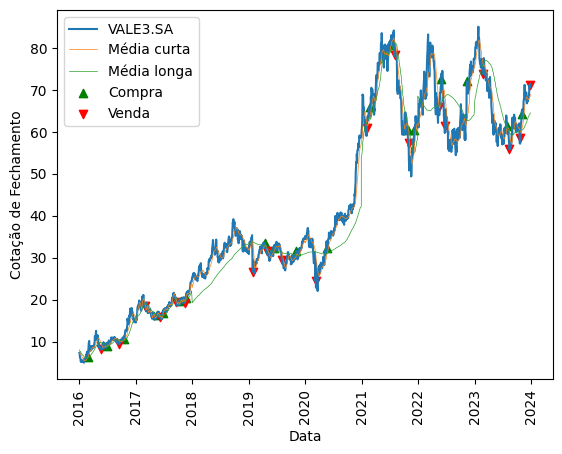

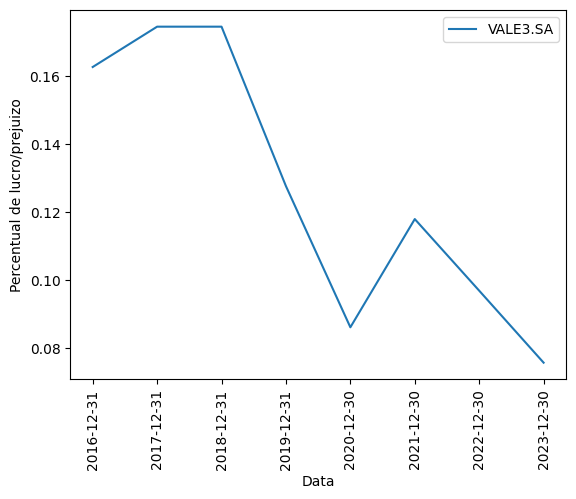

In [ ]:
acao = yf.Ticker("ELET3.SA")
dados = acao.history(start="2012-01-01", end="2023-12-31")

# mantem apenas Price
dados["Price"] = dados["Close"]
dados = dados[["Price"]]
sm = pd.DataFrame()
lm = pd.DataFrame()

data = datetime(2013, 1, 1)

ultima_compra = None

ac_vendas = []
ac_compras = []
cagrs = {}
cagrI = 0

for i in range(8):

  # define 3/4 de tempo para treino e 1/4 para teste
  inicio_treino = data.strftime("%Y-%m-%d")
  fim_treino = (data + timedelta(days=365 * 3)).strftime("%Y-%m-%d")
  inicio_teste = data + timedelta(days=365 * 3)
  fim_teste = (inicio_teste + timedelta(days=365)).strftime("%Y-%m-%d")
  inicio_teste = inicio_teste.strftime("%Y-%m-%d")

  data += timedelta(days=365)

  print("Treino: (", inicio_treino, " - ", fim_treino, "), teste: (", inicio_teste, " - ", fim_teste, ")")


  # parametros e funcao de otimizacao
  space  = [Integer(5, 20, name='periodS'),
            Integer(30, 200, name='periodL')]

  @use_named_args(space)
  def eval(**params):

      dados["position"],_,_ = SMA(dados.copy(),params['periodS'], params['periodL'])
      compras,vendas,cagr,ultima_compra = filter_data(dados.copy(), inicio_treino, fim_treino)

      # print(params, cagr)
      return -cagr

  res_gp = gp_minimize(eval, space, n_calls=50)
  solution = res_gp.x

  ultima_compra = None

  if len(ac_compras) > len(ac_vendas):
    ultima_compra = ac_compras[-1]

  dados["position"],smAux,lmAux = SMA( dados.copy(), solution[0], solution[1] )
  compras,vendas,cagr,ultima_compra = filter_data(dados, inicio_teste, fim_teste, ultima_compra)

  sm = pd.concat([sm,smAux[(smAux.index >= inicio_teste) & (smAux.index <= fim_teste)]])
  lm = pd.concat([lm,lmAux[(lmAux.index >= inicio_teste) & (lmAux.index <= fim_teste)]])

  if len(compras) > 0 and len(vendas) > 0:
    ac_compras += compras
    ac_vendas += vendas

  if ultima_compra:
    ac_compras.append(ultima_compra)

  if len(ac_compras) > 0:

    # se estiver no ultimo dia com compra aberta, sinaliza sinal de venda
    if i == 7 and len(ac_compras) > len(ac_vendas):
      ultima_data = dados.index[-1]
      ultimo_preco = dados['Price'][-1]
      print( ac_compras[-1], ultima_data)
      if ac_compras[-1] != ultima_data:
        ac_vendas.append((ultima_data,ultimo_preco))


    if len(ac_compras) == len(ac_vendas):
      valores_compra = np.array([item[1] for item in ac_compras])
    else:
      valores_compra = np.array([item[1] for item in ac_compras[:-1]])

    valores_venda = np.array([item[1] for item in ac_vendas])

    ror = (valores_venda - valores_compra)/valores_compra
    cagrI = np.power(np.prod(ror + 1), 1/len(valores_venda)) - 1

    print("parametros:", solution)
    print("cagr: ", cagrI)

  cagrs[fim_teste] = cagrI

  print("ultima compra:",ultima_compra)
  print("compras:",ac_compras)
  print("vendas:",ac_vendas)
  print("")

periodo_teste = dados[dados.index >= '2016-01-01']
plota_resultados(periodo_teste,sm,lm,ac_compras,ac_vendas,"ELET3.SA")
plota_cagr(cagrs,"ELET3.SA")
lucro = (sum([item[1] for item in ac_vendas]) - sum([item[1] for item in ac_compras])) / sum([item[1] for item in ac_compras])
resultados_experimento_cagr["SMA"] = cagrI
resultados_experimento_lucro["SMA"] = lucro

## Teste em 10 meses 2022-01 até 2022-10

# Teste TRIMA

## Teste 10 anos 2013 até 2023

In [ ]:
def TRIMA(data, periodS, periodL):

  data["sm"] = ta.TRIMA(data["Price"], periodS)
  data["lm"] = ta.TRIMA(data["Price"], periodL)

  #adiciona sinal neutro
  data["position"] = 0

  for i in range(1,len(data)):
    if data["sm"][i] > data["lm"][i] and data["sm"][i-1] <= data["lm"][i-1]: # sinal de compra
      data["position"][i] = 1
    elif data["sm"][i] < data["lm"][i] and data["sm"][i-1] >= data["lm"][i-1]: # sinal de venda
      data["position"][i] = -1

  return data["position"],data["sm"],data["lm"]

Treino: ( 2013-01-01  -  2016-01-01 ), teste: ( 2016-01-01  -  2016-12-31 )
parametros: [12, 83]
cagr:  -0.02207088315800554
ultima compra: (Timestamp('2016-10-06 00:00:00-0300', tz='America/Sao_Paulo'), 10.257532119750977)
compras: [(Timestamp('2016-03-02 00:00:00-0300', tz='America/Sao_Paulo'), 8.194500923156738), (Timestamp('2016-07-12 00:00:00-0300', tz='America/Sao_Paulo'), 10.194147109985352), (Timestamp('2016-10-06 00:00:00-0300', tz='America/Sao_Paulo'), 10.257532119750977)]
vendas: [(Timestamp('2016-05-23 00:00:00-0300', tz='America/Sao_Paulo'), 8.321280479431152), (Timestamp('2016-09-19 00:00:00-0300', tz='America/Sao_Paulo'), 9.600591659545898)]

Treino: ( 2014-01-01  -  2016-12-31 ), teste: ( 2016-12-31  -  2017-12-31 )
parametros: [5, 30]
cagr:  0.08188234576984588
ultima compra: None
compras: [(Timestamp('2016-03-02 00:00:00-0300', tz='America/Sao_Paulo'), 8.194500923156738), (Timestamp('2016-07-12 00:00:00-0300', tz='America/Sao_Paulo'), 10.194147109985352), (Timestamp('

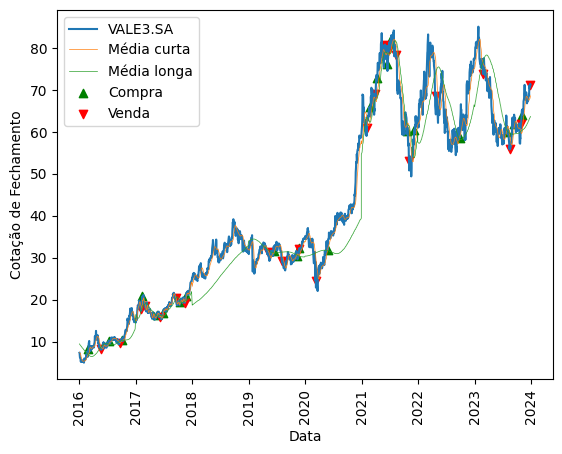

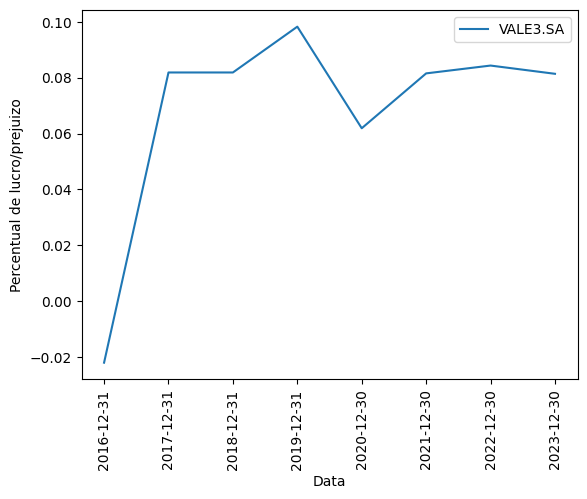

In [ ]:
acao = yf.Ticker("ELET3.SA")
dados = acao.history(start="2012-01-01", end="2023-12-31")

# mantem apenas Price
dados["Price"] = dados["Close"]
dados = dados[["Price"]]
sm = pd.DataFrame()
lm = pd.DataFrame()

data = datetime(2013, 1, 1)

ultima_compra = None

ac_vendas = []
ac_compras = []
cagrs = {}
cagrI = 0

for i in range(8):

  # define 3/4 de tempo para treino e 1/4 para teste
  inicio_treino = data.strftime("%Y-%m-%d")
  fim_treino = (data + timedelta(days=365 * 3)).strftime("%Y-%m-%d")
  inicio_teste = data + timedelta(days=365 * 3)
  fim_teste = (inicio_teste + timedelta(days=365)).strftime("%Y-%m-%d")
  inicio_teste = inicio_teste.strftime("%Y-%m-%d")

  data += timedelta(days=365)

  print("Treino: (", inicio_treino, " - ", fim_treino, "), teste: (", inicio_teste, " - ", fim_teste, ")")


  # parametros e funcao de otimizacao
  space  = [Integer(5, 20, name='periodS'),
            Integer(30, 200, name='periodL')]

  @use_named_args(space)
  def eval(**params):

      dados["position"],_,_ = TRIMA(dados.copy(),params['periodS'], params['periodL'])
      compras,vendas,cagr,ultima_compra = filter_data(dados.copy(), inicio_treino, fim_treino)

      # print(params, cagr)
      return -cagr

  res_gp = gp_minimize(eval, space, n_calls=50)
  solution = res_gp.x

  ultima_compra = None

  if len(ac_compras) > len(ac_vendas):
    ultima_compra = ac_compras[-1]

  dados["position"],smAux,lmAux = TRIMA( dados.copy(), solution[0], solution[1] )
  compras,vendas,cagr,ultima_compra = filter_data(dados, inicio_teste, fim_teste, ultima_compra)

  sm = pd.concat([sm,smAux[(smAux.index >= inicio_teste) & (smAux.index <= fim_teste)]])
  lm = pd.concat([lm,lmAux[(lmAux.index >= inicio_teste) & (lmAux.index <= fim_teste)]])

  if len(compras) > 0 and len(vendas) > 0:
    ac_compras += compras
    ac_vendas += vendas

  if ultima_compra:
    ac_compras.append(ultima_compra)

  if len(ac_compras) > 0:

    # se estiver no ultimo dia com compra aberta, sinaliza sinal de venda
    if i == 7 and len(ac_compras) > len(ac_vendas):
      ultima_data = dados.index[-1]
      ultimo_preco = dados['Price'][-1]
      print( ac_compras[-1], ultima_data)
      if ac_compras[-1] != ultima_data:
        ac_vendas.append((ultima_data,ultimo_preco))


    if len(ac_compras) == len(ac_vendas):
      valores_compra = np.array([item[1] for item in ac_compras])
    else:
      valores_compra = np.array([item[1] for item in ac_compras[:-1]])

    valores_venda = np.array([item[1] for item in ac_vendas])

    ror = (valores_venda - valores_compra)/valores_compra
    cagrI = np.power(np.prod(ror + 1), 1/len(valores_venda)) - 1

    print("parametros:", solution)
    print("cagr: ", cagrI)

  cagrs[fim_teste] = cagrI

  print("ultima compra:",ultima_compra)
  print("compras:",ac_compras)
  print("vendas:",ac_vendas)
  print("")

periodo_teste = dados[dados.index >= '2016-01-01']
plota_resultados(periodo_teste,sm,lm,ac_compras,ac_vendas,"ELET3.SA")
plota_cagr(cagrs,"ELET3.SA")
lucro = (sum([item[1] for item in ac_vendas]) - sum([item[1] for item in ac_compras])) / sum([item[1] for item in ac_compras])
resultados_experimento_cagr["TRIMA"] = cagrI
resultados_experimento_lucro["TRIMA"] = lucro

In [ ]:
def EMA(data, periodS, periodL):

  data["sm"] = ta.EMA(data["Price"], periodS)
  data["lm"] = ta.EMA(data["Price"], periodL)

  #adiciona sinal neutro
  data["position"] = 0

  for i in range(1,len(data)):
    if data["sm"][i] > data["lm"][i] and data["sm"][i-1] <= data["lm"][i-1]: # sinal de compra
      data["position"][i] = 1
    elif data["sm"][i] < data["lm"][i] and data["sm"][i-1] >= data["lm"][i-1]: # sinal de venda
      data["position"][i] = -1

  return data["position"],data["sm"],data["lm"]

Treino: ( 2013-01-01  -  2016-01-01 ), teste: ( 2016-01-01  -  2016-12-31 )
parametros: [5, 30]
cagr:  0.10153567671005082
ultima compra: None
compras: [(Timestamp('2016-02-16 00:00:00-0200', tz='America/Sao_Paulo'), 6.506042003631592), (Timestamp('2016-06-06 00:00:00-0300', tz='America/Sao_Paulo'), 9.733132362365723), (Timestamp('2016-06-23 00:00:00-0300', tz='America/Sao_Paulo'), 9.560251235961914), (Timestamp('2016-06-30 00:00:00-0300', tz='America/Sao_Paulo'), 9.375847816467285), (Timestamp('2016-09-28 00:00:00-0300', tz='America/Sao_Paulo'), 10.482279777526855)]
vendas: [(Timestamp('2016-05-09 00:00:00-0300', tz='America/Sao_Paulo'), 8.776529312133789), (Timestamp('2016-06-10 00:00:00-0300', tz='America/Sao_Paulo'), 8.615174293518066), (Timestamp('2016-06-27 00:00:00-0300', tz='America/Sao_Paulo'), 8.528735160827637), (Timestamp('2016-08-30 00:00:00-0300', tz='America/Sao_Paulo'), 10.171093940734863), (Timestamp('2016-12-22 00:00:00-0200', tz='America/Sao_Paulo'), 14.7115612030029

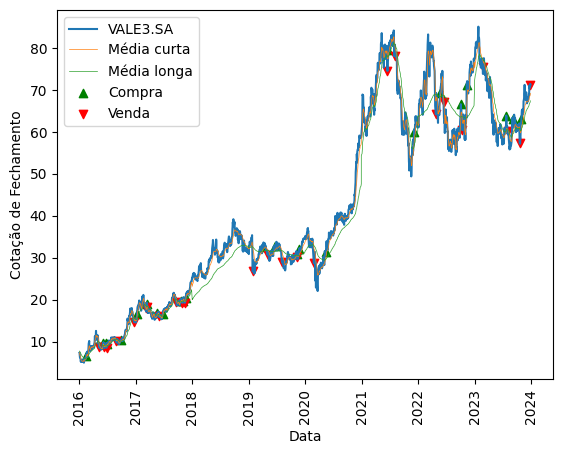

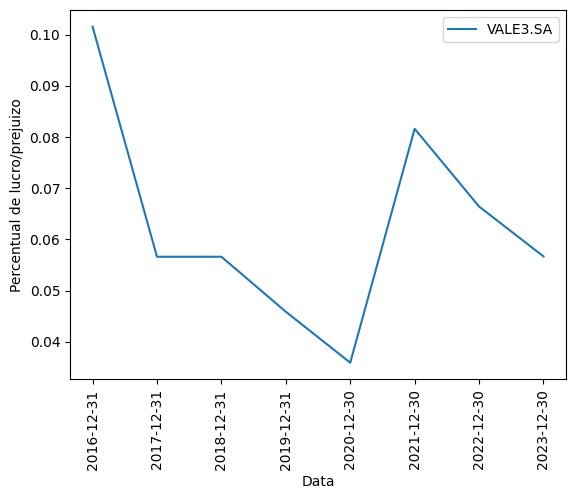

In [ ]:
acao = yf.Ticker("ELET3.SA")
dados = acao.history(start="2012-01-01", end="2023-12-31")

# mantem apenas Price
dados["Price"] = dados["Close"]
dados = dados[["Price"]]
sm = pd.DataFrame()
lm = pd.DataFrame()

data = datetime(2013, 1, 1)

ultima_compra = None

ac_vendas = []
ac_compras = []
cagrs = {}
cagrI = 0

for i in range(8):

  # define 3/4 de tempo para treino e 1/4 para teste
  inicio_treino = data.strftime("%Y-%m-%d")
  fim_treino = (data + timedelta(days=365 * 3)).strftime("%Y-%m-%d")
  inicio_teste = data + timedelta(days=365 * 3)
  fim_teste = (inicio_teste + timedelta(days=365)).strftime("%Y-%m-%d")
  inicio_teste = inicio_teste.strftime("%Y-%m-%d")

  data += timedelta(days=365)

  print("Treino: (", inicio_treino, " - ", fim_treino, "), teste: (", inicio_teste, " - ", fim_teste, ")")


  # parametros e funcao de otimizacao
  space  = [Integer(5, 20, name='periodS'),
            Integer(30, 200, name='periodL')]

  @use_named_args(space)
  def eval(**params):

      dados["position"],_,_ = EMA(dados.copy(),params['periodS'], params['periodL'])
      compras,vendas,cagr,ultima_compra = filter_data(dados.copy(), inicio_treino, fim_treino)

      # print(params, cagr)
      return -cagr

  res_gp = gp_minimize(eval, space, n_calls=50)
  solution = res_gp.x

  ultima_compra = None

  if len(ac_compras) > len(ac_vendas):
    ultima_compra = ac_compras[-1]

  dados["position"],smAux,lmAux = EMA( dados.copy(), solution[0], solution[1] )
  compras,vendas,cagr,ultima_compra = filter_data(dados, inicio_teste, fim_teste, ultima_compra)

  sm = pd.concat([sm,smAux[(smAux.index >= inicio_teste) & (smAux.index <= fim_teste)]])
  lm = pd.concat([lm,lmAux[(lmAux.index >= inicio_teste) & (lmAux.index <= fim_teste)]])

  if len(compras) > 0 and len(vendas) > 0:
    ac_compras += compras
    ac_vendas += vendas

  if ultima_compra:
    ac_compras.append(ultima_compra)

  if len(ac_compras) > 0:

    # se estiver no ultimo dia com compra aberta, sinaliza sinal de venda
    if i == 7 and len(ac_compras) > len(ac_vendas):
      ultima_data = dados.index[-1]
      ultimo_preco = dados['Price'][-1]
      print( ac_compras[-1], ultima_data)
      if ac_compras[-1] != ultima_data:
        ac_vendas.append((ultima_data,ultimo_preco))


    if len(ac_compras) == len(ac_vendas):
      valores_compra = np.array([item[1] for item in ac_compras])
    else:
      valores_compra = np.array([item[1] for item in ac_compras[:-1]])

    valores_venda = np.array([item[1] for item in ac_vendas])

    ror = (valores_venda - valores_compra)/valores_compra
    cagrI = np.power(np.prod(ror + 1), 1/len(valores_venda)) - 1

    print("parametros:", solution)
    print("cagr: ", cagrI)

  cagrs[fim_teste] = cagrI

  print("ultima compra:",ultima_compra)
  print("compras:",ac_compras)
  print("vendas:",ac_vendas)
  print("")

periodo_teste = dados[dados.index >= '2016-01-01']
plota_resultados(periodo_teste,sm,lm,ac_compras,ac_vendas,"ELET3.SA")
plota_cagr(cagrs,"ELET3.SA")
lucro = (sum([item[1] for item in ac_vendas]) - sum([item[1] for item in ac_compras])) / sum([item[1] for item in ac_compras])
resultados_experimento_cagr["EMA"] = cagrI
resultados_experimento_lucro["EMA"] = lucro

In [ ]:
def DEMA(data, periodS, periodL):

  data["sm"] = ta.DEMA(data["Price"], periodS)
  data["lm"] = ta.DEMA(data["Price"], periodL)

  #adiciona sinal neutro
  data["position"] = 0

  for i in range(1,len(data)):
    if data["sm"][i] > data["lm"][i] and data["sm"][i-1] <= data["lm"][i-1]: # sinal de compra
      data["position"][i] = 1
    elif data["sm"][i] < data["lm"][i] and data["sm"][i-1] >= data["lm"][i-1]: # sinal de venda
      data["position"][i] = -1

  return data["position"],data["sm"],data["lm"]

Treino: ( 2013-01-01  -  2016-01-01 ), teste: ( 2016-01-01  -  2016-12-31 )
parametros: [5, 31]
cagr:  0.08001619713276709
ultima compra: None
compras: [(Timestamp('2016-01-27 00:00:00-0200', tz='America/Sao_Paulo'), 5.422662258148193), (Timestamp('2016-03-16 00:00:00-0300', tz='America/Sao_Paulo'), 8.54025936126709), (Timestamp('2016-03-24 00:00:00-0300', tz='America/Sao_Paulo'), 8.672801971435547), (Timestamp('2016-04-08 00:00:00-0300', tz='America/Sao_Paulo'), 9.358559608459473), (Timestamp('2016-04-27 00:00:00-0300', tz='America/Sao_Paulo'), 11.208373069763184), (Timestamp('2016-06-03 00:00:00-0300', tz='America/Sao_Paulo'), 9.358559608459473), (Timestamp('2016-06-20 00:00:00-0300', tz='America/Sao_Paulo'), 8.972460746765137), (Timestamp('2016-06-29 00:00:00-0300', tz='America/Sao_Paulo'), 9.05313777923584), (Timestamp('2016-07-21 00:00:00-0300', tz='America/Sao_Paulo'), 10.02702808380127), (Timestamp('2016-08-17 00:00:00-0300', tz='America/Sao_Paulo'), 11.018205642700195), (Timest

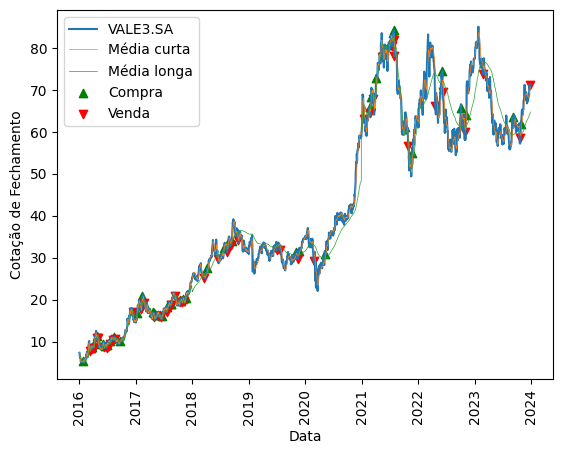

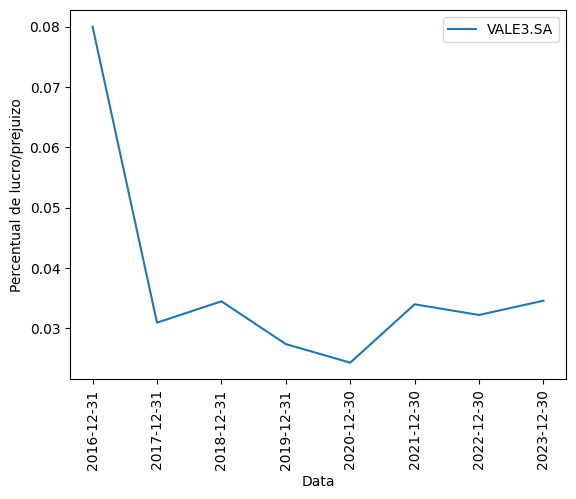

In [ ]:
acao = yf.Ticker("ELET3.SA")
dados = acao.history(start="2012-01-01", end="2023-12-31")

# mantem apenas Price
dados["Price"] = dados["Close"]
dados = dados[["Price"]]
sm = pd.DataFrame()
lm = pd.DataFrame()

data = datetime(2013, 1, 1)

ultima_compra = None

ac_vendas = []
ac_compras = []
cagrs = {}
cagrI = 0

for i in range(8):

  # define 3/4 de tempo para treino e 1/4 para teste
  inicio_treino = data.strftime("%Y-%m-%d")
  fim_treino = (data + timedelta(days=365 * 3)).strftime("%Y-%m-%d")
  inicio_teste = data + timedelta(days=365 * 3)
  fim_teste = (inicio_teste + timedelta(days=365)).strftime("%Y-%m-%d")
  inicio_teste = inicio_teste.strftime("%Y-%m-%d")

  data += timedelta(days=365)

  print("Treino: (", inicio_treino, " - ", fim_treino, "), teste: (", inicio_teste, " - ", fim_teste, ")")


  # parametros e funcao de otimizacao
  space  = [Integer(5, 20, name='periodS'),
            Integer(30, 200, name='periodL')]

  @use_named_args(space)
  def eval(**params):

      dados["position"],_,_ = DEMA(dados.copy(),params['periodS'], params['periodL'])
      compras,vendas,cagr,ultima_compra = filter_data(dados.copy(), inicio_treino, fim_treino)

      # print(params, cagr)
      return -cagr

  res_gp = gp_minimize(eval, space, n_calls=50)
  solution = res_gp.x

  ultima_compra = None

  if len(ac_compras) > len(ac_vendas):
    ultima_compra = ac_compras[-1]

  dados["position"],smAux,lmAux = DEMA( dados.copy(), solution[0], solution[1] )
  compras,vendas,cagr,ultima_compra = filter_data(dados, inicio_teste, fim_teste, ultima_compra)

  sm = pd.concat([sm,smAux[(smAux.index >= inicio_teste) & (smAux.index <= fim_teste)]])
  lm = pd.concat([lm,lmAux[(lmAux.index >= inicio_teste) & (lmAux.index <= fim_teste)]])

  if len(compras) > 0 and len(vendas) > 0:
    ac_compras += compras
    ac_vendas += vendas

  if ultima_compra:
    ac_compras.append(ultima_compra)

  if len(ac_compras) > 0:

    # se estiver no ultimo dia com compra aberta, sinaliza sinal de venda
    if i == 7 and len(ac_compras) > len(ac_vendas):
      ultima_data = dados.index[-1]
      ultimo_preco = dados['Price'][-1]
      print( ac_compras[-1], ultima_data)
      if ac_compras[-1] != ultima_data:
        ac_vendas.append((ultima_data,ultimo_preco))


    if len(ac_compras) == len(ac_vendas):
      valores_compra = np.array([item[1] for item in ac_compras])
    else:
      valores_compra = np.array([item[1] for item in ac_compras[:-1]])

    valores_venda = np.array([item[1] for item in ac_vendas])

    ror = (valores_venda - valores_compra)/valores_compra
    cagrI = np.power(np.prod(ror + 1), 1/len(valores_venda)) - 1

    print("parametros:", solution)
    print("cagr: ", cagrI)

  cagrs[fim_teste] = cagrI

  print("ultima compra:",ultima_compra)
  print("compras:",ac_compras)
  print("vendas:",ac_vendas)
  print("")

periodo_teste = dados[dados.index >= '2016-01-01']
plota_resultados(periodo_teste,sm,lm,ac_compras,ac_vendas,"ELET3.SA")
plota_cagr(cagrs,"ELET3.SA")
lucro = (sum([item[1] for item in ac_vendas]) - sum([item[1] for item in ac_compras])) / sum([item[1] for item in ac_compras])
resultados_experimento_cagr["DEMA"] = cagrI
resultados_experimento_lucro["DEMA"] = lucro

In [ ]:
def TEMA(data, periodS, periodL):

  data["sm"] = ta.TEMA(data["Price"], periodS)
  data["lm"] = ta.TEMA(data["Price"], periodL)

  #adiciona sinal neutro
  data["position"] = 0

  for i in range(1,len(data)):
    if data["sm"][i] > data["lm"][i] and data["sm"][i-1] <= data["lm"][i-1]: # sinal de compra
      data["position"][i] = 1
    elif data["sm"][i] < data["lm"][i] and data["sm"][i-1] >= data["lm"][i-1]: # sinal de venda
      data["position"][i] = -1

  return data["position"],data["sm"],data["lm"]

Treino: ( 2013-01-01  -  2016-01-01 ), teste: ( 2016-01-01  -  2016-12-31 )
parametros: [6, 30]
cagr:  0.06454600657018816
ultima compra: None
compras: [(Timestamp('2016-01-21 00:00:00-0200', tz='America/Sao_Paulo'), 5.267070770263672), (Timestamp('2016-03-01 00:00:00-0300', tz='America/Sao_Paulo'), 7.381967067718506), (Timestamp('2016-04-11 00:00:00-0300', tz='America/Sao_Paulo'), 9.779231071472168), (Timestamp('2016-05-27 00:00:00-0300', tz='America/Sao_Paulo'), 8.234840393066406), (Timestamp('2016-06-16 00:00:00-0300', tz='America/Sao_Paulo'), 8.776529312133789), (Timestamp('2016-07-26 00:00:00-0300', tz='America/Sao_Paulo'), 10.61481761932373), (Timestamp('2016-08-05 00:00:00-0300', tz='America/Sao_Paulo'), 10.931763648986816), (Timestamp('2016-09-06 00:00:00-0300', tz='America/Sao_Paulo'), 10.528380393981934), (Timestamp('2016-09-21 00:00:00-0300', tz='America/Sao_Paulo'), 10.171093940734863), (Timestamp('2016-11-07 00:00:00-0200', tz='America/Sao_Paulo'), 13.329031944274902), (Ti

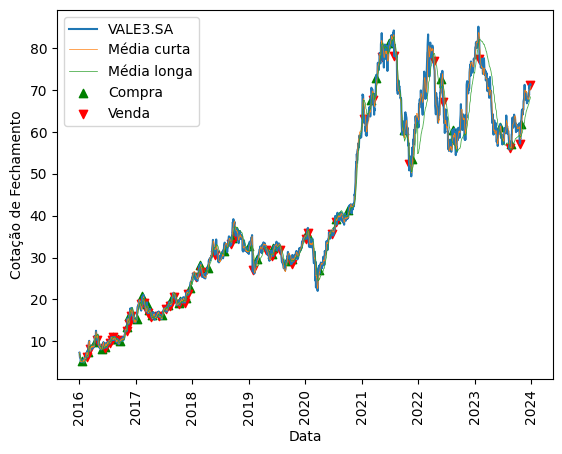

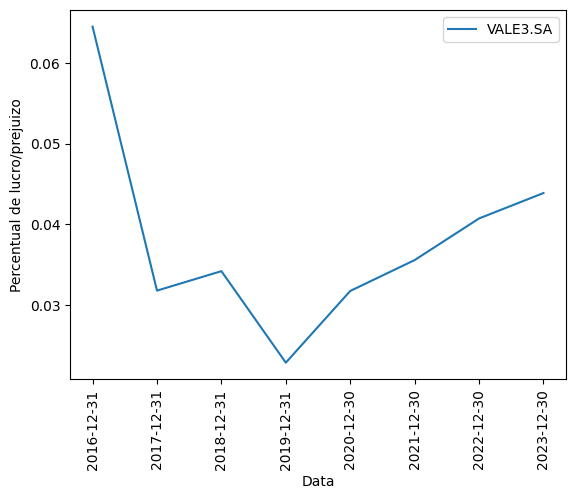

In [ ]:
acao = yf.Ticker("ELET3.SA")
dados = acao.history(start="2012-01-01", end="2023-12-31")

# mantem apenas Price
dados["Price"] = dados["Close"]
dados = dados[["Price"]]
sm = pd.DataFrame()
lm = pd.DataFrame()

data = datetime(2013, 1, 1)

ultima_compra = None

ac_vendas = []
ac_compras = []
cagrs = {}
cagrI = 0

for i in range(8):

  # define 3/4 de tempo para treino e 1/4 para teste
  inicio_treino = data.strftime("%Y-%m-%d")
  fim_treino = (data + timedelta(days=365 * 3)).strftime("%Y-%m-%d")
  inicio_teste = data + timedelta(days=365 * 3)
  fim_teste = (inicio_teste + timedelta(days=365)).strftime("%Y-%m-%d")
  inicio_teste = inicio_teste.strftime("%Y-%m-%d")

  data += timedelta(days=365)

  print("Treino: (", inicio_treino, " - ", fim_treino, "), teste: (", inicio_teste, " - ", fim_teste, ")")


  # parametros e funcao de otimizacao
  space  = [Integer(5, 20, name='periodS'),
            Integer(30, 200, name='periodL')]

  @use_named_args(space)
  def eval(**params):

      dados["position"],_,_ = TEMA(dados.copy(),params['periodS'], params['periodL'])
      compras,vendas,cagr,ultima_compra = filter_data(dados.copy(), inicio_treino, fim_treino)

      # print(params, cagr)
      return -cagr

  res_gp = gp_minimize(eval, space, n_calls=50)
  solution = res_gp.x

  ultima_compra = None

  if len(ac_compras) > len(ac_vendas):
    ultima_compra = ac_compras[-1]

  dados["position"],smAux,lmAux = TEMA( dados.copy(), solution[0], solution[1] )
  compras,vendas,cagr,ultima_compra = filter_data(dados, inicio_teste, fim_teste, ultima_compra)

  sm = pd.concat([sm,smAux[(smAux.index >= inicio_teste) & (smAux.index <= fim_teste)]])
  lm = pd.concat([lm,lmAux[(lmAux.index >= inicio_teste) & (lmAux.index <= fim_teste)]])

  if len(compras) > 0 and len(vendas) > 0:
    ac_compras += compras
    ac_vendas += vendas

  if ultima_compra:
    ac_compras.append(ultima_compra)

  if len(ac_compras) > 0:

    # se estiver no ultimo dia com compra aberta, sinaliza sinal de venda
    if i == 7 and len(ac_compras) > len(ac_vendas):
      ultima_data = dados.index[-1]
      ultimo_preco = dados['Price'][-1]
      print( ac_compras[-1], ultima_data)
      if ac_compras[-1] != ultima_data:
        ac_vendas.append((ultima_data,ultimo_preco))


    if len(ac_compras) == len(ac_vendas):
      valores_compra = np.array([item[1] for item in ac_compras])
    else:
      valores_compra = np.array([item[1] for item in ac_compras[:-1]])

    valores_venda = np.array([item[1] for item in ac_vendas])

    ror = (valores_venda - valores_compra)/valores_compra
    cagrI = np.power(np.prod(ror + 1), 1/len(valores_venda)) - 1

    print("parametros:", solution)
    print("cagr: ", cagrI)

  cagrs[fim_teste] = cagrI

  print("ultima compra:",ultima_compra)
  print("compras:",ac_compras)
  print("vendas:",ac_vendas)
  print("")

periodo_teste = dados[dados.index >= '2016-01-01']
plota_resultados(periodo_teste,sm,lm,ac_compras,ac_vendas,"ELET3.SA")
plota_cagr(cagrs,"ELET3.SA")
lucro = (sum([item[1] for item in ac_vendas]) - sum([item[1] for item in ac_compras])) / sum([item[1] for item in ac_compras])
resultados_experimento_cagr["TEMA"] = cagrI
resultados_experimento_lucro["TEMA"] = lucro

[*********************100%%**********************]  1 of 1 completed


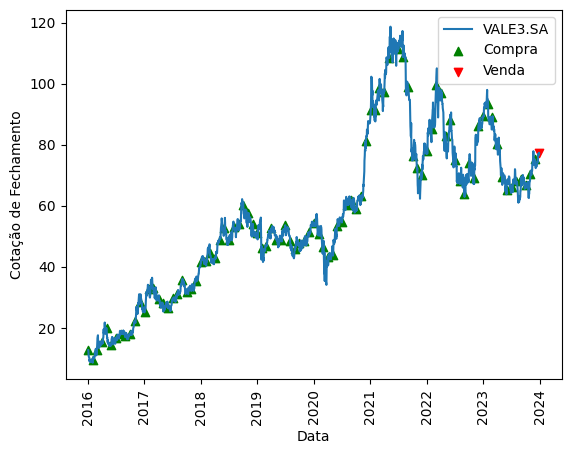



datas de compras ['2016-01-04' '2016-02-01' '2016-03-01' '2016-04-01' '2016-05-02'
 '2016-06-01' '2016-07-01' '2016-08-01' '2016-09-01' '2016-10-03'
 '2016-11-01' '2016-12-01' '2017-01-02' '2017-02-01' '2017-03-01'
 '2017-04-03' '2017-05-02' '2017-06-01' '2017-07-03' '2017-08-01'
 '2017-09-01' '2017-10-02' '2017-11-01' '2017-12-01' '2018-01-02'
 '2018-02-01' '2018-03-01' '2018-04-02' '2018-05-02' '2018-06-01'
 '2018-07-02' '2018-08-01' '2018-09-03' '2018-10-01' '2018-11-01'
 '2018-12-03' '2019-01-02' '2019-02-01' '2019-03-01' '2019-04-01'
 '2019-05-02' '2019-06-03' '2019-07-01' '2019-08-01' '2019-09-02'
 '2019-10-01' '2019-11-01' '2019-12-02' '2020-01-02' '2020-02-03'
 '2020-03-02' '2020-04-01' '2020-05-04' '2020-06-01' '2020-07-01'
 '2020-08-03' '2020-09-01' '2020-10-01' '2020-11-03' '2020-12-01'
 '2021-01-04' '2021-02-01' '2021-03-01' '2021-04-01' '2021-05-03'
 '2021-06-01' '2021-07-01' '2021-08-02' '2021-09-01' '2021-10-01'
 '2021-11-01' '2021-12-01' '2022-01-03' '2022-02-01' '202

In [ ]:
dados = yf.download('ELET3.SA', start='2016-01-01', end='2023-12-31')
d2 = dados.copy()
ultimo_preco = dados['Close'].iloc[-1]
ultima_data = dados.index[-1]

#primeiro dia de cada mes
dados.reset_index(inplace=True)
dados['Inicio_Mes'] = dados['Date'].dt.to_period('M').dt.to_timestamp()
primeiros_dias = dados.groupby('Inicio_Mes').first()[['Date', 'Close']]
resultados = [(row['Date'], row['Close']) for _, row in primeiros_dias.iterrows()]

d_compras = np.array([str(item[0])[0:10] for item in resultados])
v_compras = np.array([item[1] for item in resultados])
v_vendas = np.array([ultimo_preco]*len(v_compras))

ror = (v_vendas - v_compras)/v_compras
cagrI = np.power(np.prod(ror + 1), 1/len(v_vendas)) - 1
lucro = (sum(v_vendas) - sum(v_compras))/sum(v_compras)

plt.plot(d2["Close"],label='ELET3.SA')
plt.scatter(d_compras,v_compras,marker="^",color="green",label="Compra")
plt.scatter(ultima_data,ultimo_preco,marker="v",color="red",label="Venda")
plt.xlabel("Data")
plt.ylabel("Cotação de Fechamento")
plt.xticks(rotation=90)
plt.legend()
plt.show()

print("\n")
print("datas de compras", d_compras)
print("data de venda", ultima_data)
print("compras:", v_compras)
print("vendas:", v_vendas)
print("Lucro:",lucro)

resultados_experimento_lucro["BL1"] = lucro
resultados_experimento_cagr["BL1"] = cagrI

[*********************100%%**********************]  1 of 1 completed



compras: ['2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', '2017-01-02', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-02', '2017-06-01', '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-02', '2018-06-01', '2018-07-02', '2018-08-01', '2018-09-03', '2018-10-01', '2018-11-01', '2018-12-03', '2019-01-02', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-02', '2019-06-03', '2019-07-01', '2019-08-01', '2019-09-02', '2019-10-01', '2019-11-01', '2019-12-02', '2020-01-02', '2020-02-03', '2020-03-02', '2020-04-01', '2020-05-04', '2020-06-01', '2020-07-01', '2020-08-03', '2020-09-01', '2020-10-01', '2020-11-03', '2020-12-01', '2021-01-04', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-03', '2021-06-01', '2021-07-01', '2021-08-02', '2021-09-01', '2021-10-01', '2021-11

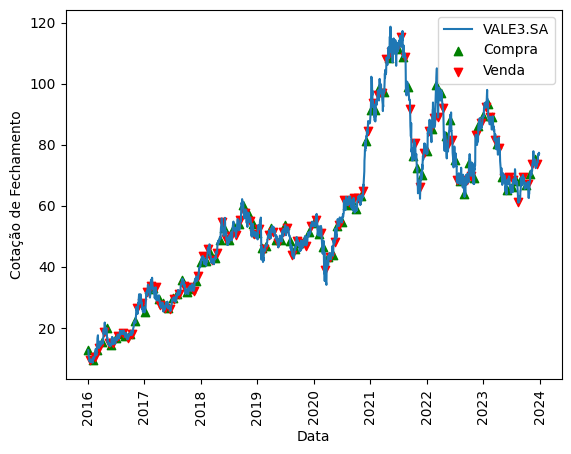

\LUCRO: 0.005190139185343699


In [ ]:
dados = yf.download('ELET3.SA', start='2016-01-01', end='2023-12-31')
d2 = dados.copy()
dados.reset_index(inplace=True)

# Adicionar coluna com o início do mês
dados['Inicio_Mes'] = dados['Date'].dt.to_period('M').dt.to_timestamp()

# Adicionar coluna para o meio do mês
dados['Meio_Do_Mes'] = dados['Inicio_Mes'] + pd.DateOffset(days=14)

# Obter o primeiro dia do mês
primeiros_dias = dados.groupby('Inicio_Mes').first()[['Date', 'Close']]
primeiros_dias.reset_index(drop=True, inplace=True)
primeiros_dias.columns = ['Data', 'Preço de Fechamento']

# Obter o meio do mês
resultados_meio = []
for periodo, grupo in dados.groupby('Inicio_Mes'):
    meio_do_mes = periodo + pd.DateOffset(days=14)
    mais_proximo = grupo.loc[(grupo['Date'] - meio_do_mes).abs().idxmin()]
    resultados_meio.append((mais_proximo['Date'], mais_proximo['Close']))

# Converter para DataFrame
meio_dias = pd.DataFrame(resultados_meio, columns=['Data', 'Preço de Fechamento'])

# Convertendo os preços em arrays
d_compras = [ str(data)[0:10] for data in primeiros_dias['Data'].values ]
v_compras = primeiros_dias['Preço de Fechamento'].values
d_vendas = [ str(data)[0:10] for data in meio_dias['Data'].values ]
v_vendas = meio_dias['Preço de Fechamento'].values

# Calcular o retorno e o CAGR
ror = (v_vendas - v_compras)/v_compras
cagrI = np.power(np.prod(ror + 1), 1/len(v_vendas)) - 1
lucro = (sum(v_vendas) - sum(v_compras))/sum(v_compras)

print("\n")
print("compras:", d_compras)
print("vendas:", d_vendas)

print("\n")
print("compras:", v_compras)
print("vendas:", v_vendas)

plt.plot(d2["Close"],label='ELET3.SA')
plt.scatter(d_compras,v_compras,marker="^",color="green",label="Compra")
plt.scatter(d_vendas,v_vendas,marker="v",color="red",label="Venda")
plt.xlabel("Data")
plt.ylabel("Cotação de Fechamento")
plt.xticks(rotation=90)
plt.legend()
plt.show()

print("\LUCRO:", lucro)
resultados_experimento_lucro["BL2"] = lucro
resultados_experimento_cagr["BL2"] = cagrI

In [ ]:
print("ELET3.SA")
print("CAGR:")
print(resultados_experimento_cagr)
print("Lucro")
print(resultados_experimento_lucro)

VALE3.SA
CAGR:
{'SMA': 0.07573724504274915, 'TRIMA': 0.08140658404404144, 'EMA': 0.0566642300956377, 'DEMA': 0.034597919135719524, 'TEMA': 0.04388649216805085, 'BL1': 0.5478860424219372, 'BL2': 0.00468180634551052}
Lucro
{'SMA': 0.04491794577631707, 'TRIMA': 0.07585857808947154, 'EMA': 0.05141871980813009, 'DEMA': 0.028842405986965726, 'TEMA': 0.05160576904782633, 'BL1': 0.36015264725975593, 'BL2': 0.005190139185343699}
